In [1]:
import torch
from chapter04 import GPTModel
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,        #A
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,             #B
    "qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

#A 我们将上下文长度从1024个token缩短到256个token
#B 将 dropout 设置为 0 是一种常见的做法

D:\anaconda\envs\mine\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [2]:
# Listing 5.1 Utility functions for text to token ID conversion
import tiktoken
from chapter04 import generate_text_simple

In [3]:
# allowed_special={'<|endoftext|>'}
start_context = "Every effort moves you"
def text_to_token_ids(text, tokenizer):
    ids=tokenizer.encode(text,allowed_special={'<|endoftext|>'})
    return torch.tensor(ids).unsqueeze(0)
    
def token_ids_to_text(token_ids, tokenizer):
    text=tokenizer.decode(token_ids.squeeze(0).tolist())
    return text
tokenizer=tiktoken.get_encoding('gpt2')
ids=text_to_token_ids(start_context,tokenizer)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)
token_ids_to_text(token_ids,tokenizer)

'Every effort moves you rentingetic wasnم refres RexMeCHicular stren'

In [4]:
inputs = torch.tensor([[16833, 3626, 6100], # ["every effort moves",
                       [40, 1107, 588]])    # "I really like"]
# Matching these inputs, the `targets` contain the token IDs we aim for the model to produce:
targets = torch.tensor([[3626, 6100, 345 ], # [" effort moves you",
                        [107, 588, 11311]]) # " really like chocolate"]

In [5]:
with torch.no_grad():
    logits=model(inputs)
probas=torch.softmax(logits,dim=-1)
outputs=probas.argmax(dim=-1,keepdim=True)
outputs

tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])

In [6]:
for i in outputs:
    print(i.reshape(1,-1))
    print(token_ids_to_text(i.reshape(1,-1),tokenizer))

tensor([[16657,   339, 42826]])
 Armed heNetflix
tensor([[49906, 29669, 41751]])
 pressuring empoweredfaith


In [7]:
text_idx = 0

# 三维向量索引规则，得到的是概率
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)
targets[0]

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([3.9108e-05, 5.6776e-05, 4.7559e-06])


tensor([3626, 6100,  345])

In [8]:
# cat在每行的列上拼接
log_probas=torch.log(torch.cat((target_probas_1,target_probas_2)))
log_probas

tensor([ -9.5042, -10.3796, -11.3677, -10.1492,  -9.7764, -12.2561])

In [9]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.5722)


In [10]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.5722)


In [11]:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [12]:
# 交叉熵损失函数
torch.nn.functional.cross_entropy(logits.reshape(-1,logits.shape[-1]),targets.reshape(-1))

tensor(10.5722)

In [13]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20480
Tokens: 5146


In [14]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [15]:
from chapter02 import create_dataloader_v1
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [16]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [17]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch=input_batch.to(device)
    target_batch=target_batch.to(device)
    outputs=model(input_batch)
    
    # flatten可以合并维度
    # 先放out再放target
    loss=torch.nn.functional.cross_entropy(outputs.flatten(0,1),target_batch.flatten())
    
    return loss

In [18]:
# Listing 5.2 Function to compute the training and validation loss
def calc_loss_loader(data_loader, model, device, num_batches=None):
    loss_sum=0.0
    if len(data_loader)==0:
        return float('nan')
    elif num_batches is None:
        num_batches=len(data_loader)
    else:
        num_batches=min(len(data_loader),num_batches)
    for i,(x,y) in enumerate(data_loader):
        if i>num_batches:
            break
        l=calc_loss_batch(x,y,model,device)
        loss_sum+=l.item()
    print(f'all loss is {loss_sum/num_batches}')
    return loss_sum/num_batches

In [19]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=model.to(device)
with torch.no_grad():
    train_loss=calc_loss_loader(train_loader,model,device)
    valid_loss=calc_loss_loader(train_loader,model,device)
print(f'train_loss:{train_loss}')
print('valid_loss:{0:}'.format(valid_loss))

all loss is 10.987583372328016
all loss is 10.987583266364204
train_loss:10.987583372328016
valid_loss:10.987583266364204


In [20]:
import gc
# Listing 5.3 The main function for pretraining LLMs
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses,val_losses,track_tokens=[],[],[]
    global_step=-1
    token_seen=0
    
    for epoch in range(num_epochs):
        # 每个epoch train
        model.train()
        for x,y in train_loader:
            optimizer.zero_grad()
            l=calc_loss_batch(x,y, model=model, device=device)
            l.backward()
            optimizer.step()
            global_step+=1
            token_seen+=x.numel()
            
            if global_step% eval_freq==0:
                train_loss,val_loss=evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens.append(token_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
                
        generate_and_print_sample(                                                 
            model, tokenizer, device, start_context
        )
        gc.collect()
        torch.cuda.empty_cache()
    return train_losses,val_losses,track_tokens
                
    

In [21]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss=calc_loss_loader(train_loader, model, device)
        val_loss=calc_loss_loader(val_loader, model, device)
    model.train()
    return train_loss,val_loss

In [22]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size=model.pos_emb.weight.shape[0]
    encoded=text_to_token_ids(start_context,tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
        text=token_ids_to_text(token_ids,tokenizer)
    
        print(text.replace('\n',''))
    model.train()

In [23]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)      #A
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=1,
    start_context="Every effort moves you", tokenizer=tokenizer
)

#A .parameters() 方法返回模型的所有可训练权重参数

all loss is 9.766464021470812
all loss is 9.927428245544434
Ep 1 (Step 000000): Train loss 9.766, Val loss 9.927
all loss is 8.069049729241264
all loss is 8.334250450134277
Ep 1 (Step 000005): Train loss 8.069, Val loss 8.334
Every effort moves you,,,,,,,,,,,,.
all loss is 6.726918008592394
all loss is 7.050800323486328
Ep 2 (Step 000010): Train loss 6.727, Val loss 7.051
all loss is 6.103990607791477
all loss is 6.602636814117432
Ep 2 (Step 000015): Train loss 6.104, Val loss 6.603
Every effort moves you, the,, and,,,,,,, and,.
all loss is 5.6177341143290205
all loss is 6.502573013305664
Ep 3 (Step 000020): Train loss 5.618, Val loss 6.503
all loss is 5.43874979019165
all loss is 6.3662309646606445
Ep 3 (Step 000025): Train loss 5.439, Val loss 6.366
Every effort moves you, and to the of the of the of the, and I had. Gis, and, and, and, and, and, and I had, and, and, and, and, and, and, and, and, and,
all loss is 5.022319740719265
all loss is 6.2828216552734375
Ep 4 (Step 000030): Tra

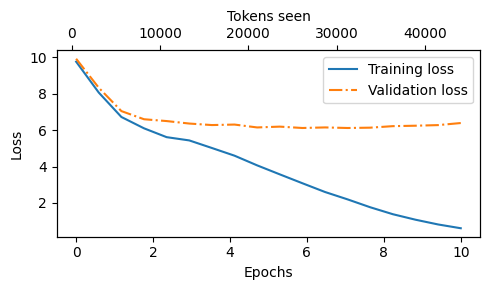

In [24]:
import matplotlib.pyplot as plt
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax2 = ax1.twiny() #A
    ax2.plot(tokens_seen, train_losses, alpha=0) #B
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

#A 创建与 y 轴共用的第二个 x 轴
#B 用于对齐刻度的隐藏图形

In [25]:
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [26]:
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




In [27]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}
inverse_vocab = {v: k for k, v in vocab.items()}

In [28]:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [31]:
prob=torch.softmax(next_token_logits,dim=0)
ids=prob.argmax(dim=-1)
inverse_vocab[ids.item()]

'forward'

In [32]:
torch.manual_seed(123)
# 采用temperature scaling：multinomial和temperature
# temperature 值非常小时，生成的概率分布会更加尖锐，越大时，概率分布会更加均匀
# 越大时，由于 exp 函数的敏感性较高，这意味着 logits 值的差异被“压平”，使得最优词的概率降低，而其他次优词的概率提高。输出的概率分布变得更加均匀
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)
torch.multinomial(prob,num_samples=1)

tensor([3])

In [33]:
# topk筛选最适合的前k个
top_k=3
# 返回值是value,index
val,idx=torch.topk(next_token_logits,top_k)
print(val,idx)

tensor([6.7500, 6.2800, 4.5100]) tensor([3, 7, 0])


In [35]:
# 使用where将top_k之外的值置-inf
torch.where(condition=next_token_logits<val[-1],input=torch.tensor(float('-inf')),other=next_token_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])

In [47]:
# Listing 5.4 A modified text generation function with more diversity
def generate(model, idx, max_new_tokens, context_size,
             temperature=1.0, top_k=None, eos_id=None):
    
    for _ in range(max_new_tokens):
        id_con=idx[:,-context_size:]
        with torch.no_grad():
            digits=model(id_con)
        digits=digits[:,-1,:]
        if top_k is not None:
            top_digits,_=torch.topk(digits,top_k)
            digits=torch.where(
                condition=digits>top_digits[:,-1],
                input=torch.tensor(float('-inf')).to(digits.device),
                other=digits
            )
            
        
        if temperature>0.0:
            digits=digits/temperature
            digits=torch.softmax(digits,dim=-1)     
            digits=torch.multinomial(digits,num_samples=1)
        else:
            digits=torch.softmax(digits,dim=-1)
            digits=digits.argmax(dim=-1,keepdim=True)
        idx=torch.cat((idx,digits),dim=1)
        # 如果遇到序列结束token且指定了eos_id，则提前停止生成
        if digits==eos_id:
            break
    return idx

In [48]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves youThen studio rewardedrow ConfederingAnnaenezYesSTAT Granted_> downed Mars Doyle


In [51]:
# 保存模型参数和优化器参数
torch.save({
    'model_state_dict':model.state_dict(),
    'optimizer_state_dict':optimizer.state_dict()
},'model_opt.pth')

In [54]:
# 加载参数
checkpoint=torch.load('model_opt.pth')
model=GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer=torch.optim.AdamW(model.parameters(),lr=1e-3,weight_decay=0.1)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.train()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [57]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

checkpoint: 100%|██████████████████████████████████████████████████████████████████████████| 77.0/77.0 [00:00<?, ?iB/s]
encoder.json: 100%|███████████████████████████████████████████████████████████████| 1.04M/1.04M [00:02<00:00, 416kiB/s]
hparams.json: 100%|████████████████████████████████████████████████████████████████████████| 90.0/90.0 [00:00<?, ?iB/s]
model.ckpt.data-00000-of-00001: 100%|███████████████████████████████████████████████| 498M/498M [12:12<00:00, 680kiB/s]
model.ckpt.index: 100%|███████████████████████████████████████████████████████████| 5.21k/5.21k [00:00<00:00, 379kiB/s]
model.ckpt.meta: 100%|██████████████████████████████████████████████████████████████| 471k/471k [00:01<00:00, 266kiB/s]
vocab.bpe: 100%|████████████████████████████████████████████████████████████████████| 456k/456k [00:01<00:00, 286kiB/s]


In [58]:
#将 GPT-2 的架构设置（settings）和权重参数（params）加载到 Python 会话中
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])
[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [59]:
# First, we create a dictionary that lists the differences between the different GPT model sizes, as explained in Figure 5.17:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
# Suppose we are interested in loading the smallest model, "gpt2-small (124M)". We can use the corresponding settings from the model_configs table able to update our full-length GPT_CONFIG_124M we defined and used earlier throughout the chapter as follows:
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
# 之前设置的 token 长度是 256，但 OpenAI 的原始 GPT-2 模型使用的是 1,024 的 token 长度，因此我们需要相应地更新 NEW_CONFIG:
NEW_CONFIG.update({"context_length": 1024})

In [60]:
NEW_CONFIG.update({"qkv_bias": True})
# We can now use the updated NEW_CONFIG dictionary to initialize a new GPTModel instance:
gpt = GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [64]:
from torch import nn
def assign(left,right):
    if left.shape!=right.shape:
        raise ValueError(f'shape not consi{left.shape}:{right.shape}')
    return nn.Parameter(torch.tensor(right))

In [65]:
# Listing 5.5 Loading OpenAI weights into our GPT model code
import numpy as np
#将 `params` 字典中的权重加载到 GPT 模型实例中：
def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])               #A
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    for b in range(len(params["blocks"])):                                       #B
        q_w, k_w, v_w = np.split(                                                #C
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])                   #D


#A 将模型的位置嵌入和token 嵌入的权重设置为 params 中指定的值
#B 遍历模型中的每个 Transformer 模块
#C 使用 np.split 函数将注意力和偏置权重分为三等份，分别用于查询、键和值组件
#D OpenAI 的原始 GPT-2 模型在输出层中复用了 token 嵌入的权重，以减少参数总量，这一概念称为权重共享

In [68]:
load_weights_into_gpt(gpt, params)
device='cpu'
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [69]:
torch.manual_seed(123)
token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you leaps shortly knock rapidly performTweet laterZBOX Space reductorsRe MayRe IV Opsluence yVR Analog BettyDr34Fire
